## Summary of data
## Properties from San Jose, CA
## 6099 condos
## 92 different neighborhoods

In [1]:
PROPERTY_TYPES = ['condo', 'townhouse', 'multiunit', 'singlefamily']
TRESH = 0.15
NUM_BINS = 5
BINS = []

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
          'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
         'Nov', 'Dec']

COLS_EXCLUDE = ['Median Sale Price','Region','neighborhood',
                'location','city','property_type','state',
                'Month of Period End', 'Median_Sale_Price_Bin', 'neighborhood_num']

In [2]:
import csv
import itertools
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import confusion_matrix
from string import punctuation

In [3]:
def make_histogram(data, bins):
    fig, ax = plt.subplots()

    # histogram our data with numpy
    n, bins = np.histogram(data, bins)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n


    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    plt.show()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.around(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# convert string percentages to numerical
def convert_percentage(df):
    for col in df.columns:
        c = col.split(" ")
        if c[-1] == "MoM" or c[-1] == "YoY": 
            df[col] = [float(str(x).strip("%")) for x in df[col]]
    
    df['Average Sale To List'] = [float(str(x).strip("%")) for x in df['Average Sale To List']]

In [6]:
### read in data
def read_data(filename, property_type):
    df = pd.read_csv(filename)
    df.columns = [x.strip(" ") for x in df.columns]
    df['property_type'] = property_type
    df['property_type_num'] = PROPERTY_TYPES.index(property_type)
    df.head()
    return (df)

In [7]:
### add columns for city, state, and neighborhood
def parse_region(df):
    df['location'] = [x.split(",") for x in df.Region]
    df['city'] = [x[0].strip(",").lower() for x in df.location]
    df['state'] = [x[1].split(" ")[1].lower().strip() for x in df.location]
    df['neighborhood'] = [x[1].split(" ")[3].strip().lower() for x in df.location]
    df = df[df.city == 'san jose']
    df.head()

In [8]:
### convert Median Sale Price to a float
def convert_med_sale_pr(df):
    df[u'Median Sale Price'] = [x.strip("$").replace(",", "") for x in df["Median Sale Price"]]
    df[u'Median Sale Price'] = [int(x) if x[len(x)-1] != "K" else int(x.strip("K"))*1000 
                                for x in df["Median Sale Price"]]

In [9]:
### convert neighborhood to a numerical value
def convert_neighborhood(df):
    neighborhoods = df.neighborhood.unique()
    df['neighborhood_num'] = [np.where(neighborhoods == x)[0][0] for x in df.neighborhood]

In [10]:
# encode catgorial variable so that it can be used
# in regression
def encode_categorial(df):
    neighborhoods = df.neighborhood.unique()
    for n in neighborhoods:
        df[n] = [1 if x == n else 0 for x in df.neighborhood]
    return (df)

In [11]:
# take median sale prices, bin, and add a column 
# that represents price ranges
def bin_med_sale_pr(df, bins):
    med_sale_pr = df['Median Sale Price']
    bins = np.linspace(med_sale_pr.min(), med_sale_pr.max(), bins)
    digitized = np.digitize(med_sale_pr, bins)
    df['Median_Sale_Price_Bin'] = digitized
    return (df, bins)

In [12]:
# Take date and turn it into month and year
def parse_date(df):
    df['Month of Period End'] = [x.replace('-', ' ') for x in df['Month of Period End']]
    df['Month'] = [MONTHS.index(x.split(' ')[0][:3]) for x in df['Month of Period End']]
    df['Year'] = [int(x.split(' ')[1]) for x in df['Month of Period End']]
    return (df)

In [13]:
def filter_prices(df, high, low):
    t_cutoff = np.percentile(sorted(df['Median Sale Price']), high)
    b_cutoff = np.percentile(sorted(df['Median Sale Price']), low)
    df = df[df['Median Sale Price'] <= t_cutoff]
    df = df[df['Median Sale Price'] >= b_cutoff]
    return (df)

In [14]:
### given the filename and property type return
### a dataframe with string fields converted to
### numerical and regions parsed out
def clean_data(filename, property_type):
    df = read_data(filename, property_type)
    convert_med_sale_pr(df)
    parse_region(df)
    convert_percentage(df)
    convert_neighborhood(df)
    df = parse_date(df)
    df = filter_prices(df, 75, 10)
    return (df)

In [15]:
# merge several dataframes together
# files = list of tuples, 
# each tuple should contain filename first then property type

# How to deal with NA's? fill with 0 for now ...
def merge_data(files):
    frames = []
    for f in files:
        frames.append(clean_data(f[0], f[1]))
    
    df = pd.concat(frames).fillna(method='ffill')
    return (df)

In [16]:
# x_train has 70% of the dataset
# x_test has 30% of the dataset
# ignore y_train and y_test
# Regression: Train on x_train, remove non-numerical columns first!
# Test on x_test

# splits dataset up into training (70%) and testing (30%) sets
# evenly based on neighborhood

def split_test_train(total, stratify_col):
    total2 = total.copy(deep=True)
    y = total2[stratify_col]
    x = total2
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
    return (x_train, x_test, y_train, y_test)

In [17]:
# fits a regression model to a training set
def model(x_train, model, label, cols_exclude=COLS_EXCLUDE):
    X = x_train.loc[:, x_train.columns.difference(cols_exclude)]
    Y = x_train.loc[:, label]
    model.fit(X, Y)
    return (model)

In [18]:
def predict(x_test, model, label):
    X_test = x_test.loc[:, x_train.columns.difference(COLS_EXCLUDE)]
    Y_test = x_test.loc[:, label]
    return (model.predict(X_test), Y_test)


In [19]:
# how many of the predicted prices were within
# thresh % of the actual price?
# return a ratio

def evaluate(y_pred, y_test, thresh):
    assert len(y_pred) == len(y_test)
    result = []
    for (pred, test) in zip(y_pred, y_test):
        result.append(math.fabs((test-pred)/test) <= thresh)
    
    return (float(sum(result))/float(len(result)))

In [20]:
files = [('sanjose_condos.csv', PROPERTY_TYPES[0]), ('sanjose_townhouse2.csv', PROPERTY_TYPES[1]),
        ('sanjose_multiunit.csv', PROPERTY_TYPES[2]), ("sanjose_singlefamily.csv", PROPERTY_TYPES[3])]
total = merge_data(files)
total, bins = bin_med_sale_pr(total, NUM_BINS)

In [21]:
total.columns

Index([u'Region', u'Month of Period End', u'Median Sale Price',
       u'Median Sale Price MoM', u'Median Sale Price YoY', u'Homes Sold',
       u'Homes Sold MoM', u'Homes Sold YoY', u'New Listings',
       u'New Listings MoM', u'New Listings YoY', u'Inventory',
       u'Inventory MoM', u'Inventory YoY', u'Days on Market',
       u'Days on Market MoM', u'Days on Market YoY', u'Average Sale To List',
       u'Average Sale To List MoM', u'Average Sale To List YoY',
       u'property_type', u'property_type_num', u'location', u'city', u'state',
       u'neighborhood', u'neighborhood_num', u'Month', u'Year',
       u'Median_Sale_Price_Bin'],
      dtype='object')

In [22]:
total.head()

,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,...,property_type,property_type_num,location,city,state,neighborhood,neighborhood_num,Month,Year,Median_Sale_Price_Bin
41,"San Jose, CA - Alexander",June 2015,352000,6.3,30.6,3,-25.0,-25.0,9.0,-10.0,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,5,2015,1
45,"San Jose, CA - Alexander",October 2015,335000,7.0,35.6,8,-27.3,33.3,10.0,11.1,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,9,2015,1
47,"San Jose, CA - Alexander",December 2015,345000,16.7,20.0,12,100.0,100.0,12.0,0.0,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,11,2015,1
48,"San Jose, CA - Alexander",January 2016,338000,-2.2,25.0,14,16.7,180.0,9.0,-25.0,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,0,2016,1
49,"San Jose, CA - Alexander",February 2016,365000,8.1,29.2,13,-7.1,116.7,6.0,-33.3,...,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,1,2016,1


### Linear Regression Model to predict median sale price from feature list

In [23]:
lin_reg_df = encode_categorial(total.copy())
x_train, x_test, _, _ = split_test_train(lin_reg_df, 'Median_Sale_Price_Bin')
reg = model(x_train, linear_model.Lasso(alpha=0.5), 'Median Sale Price')

np.set_printoptions(precision=3, suppress=True)
cols = x_train.loc[:, x_train.columns.difference(COLS_EXCLUDE)].columns[:19]
coeff = np.array(reg.coef_)[:19]

for (col, coeff) in zip(cols, coeff):
    print (col,coeff)

('Average Sale To List', 7916.496842507624)
('Average Sale To List MoM', -2162.9746605596624)
('Average Sale To List YoY', -4216.8077561138298)
('Days on Market', 53.761880797988944)
('Days on Market MoM', -70.096795753078396)
('Days on Market YoY', 213.46751174946803)
('Homes Sold', 4.2455966469604052)
('Homes Sold MoM', -11.568599106665117)
('Homes Sold YoY', 11.35603398629944)
('Inventory', -2.7095530322102754)
('Inventory MoM', -11.470731427016972)
('Inventory YoY', 48.219501309930699)
('Median Sale Price MoM', 859.39023484305483)
('Median Sale Price YoY', 362.7973834410181)
('Month', 3170.2235829674519)
('New Listings', 2.4468645295694795)
('New Listings MoM', -22.969770603563362)
('New Listings YoY', 80.487367621710888)
('Year', 67.981796831973995)


//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [24]:
Y_pred, Y_test = predict(x_test, reg, 'Median Sale Price')

In [25]:
for t in [0.05, 0.10, 0.15, 0.25]:
    print (evaluate(Y_pred, Y_test, t))

0.222148541114
0.417108753316
0.612400530504
0.829907161804


### Look at price distribution in training and test sets

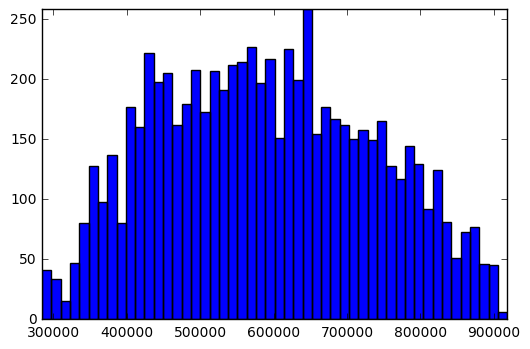

In [26]:
make_histogram(x_train['Median Sale Price'], 50)

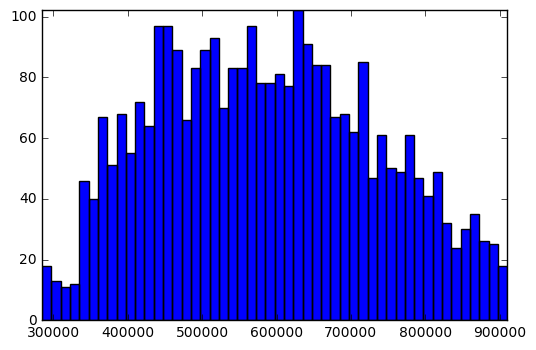

In [27]:
make_histogram(x_test['Median Sale Price'], 50)

### Decision tree classifier

In [30]:
x_train, x_test, _, _ = split_test_train(total, 'Median_Sale_Price_Bin')
r_forest = model(x_train, ensemble.RandomForestClassifier(n_estimators=1000), 
                 'Median_Sale_Price_Bin')

In [31]:
Y_pred, Y_test = predict(x_test, r_forest, 'Median_Sale_Price_Bin')

In [32]:
len(Y_pred)

3016

In [33]:
len(Y_test)

3016

In [34]:
print (Y_pred[:10], np.unique(Y_pred))

(array([2, 2, 2, 2, 3, 2, 2, 2, 2, 1]), array([1, 2, 3, 4]))


In [35]:
Y_test[:10]

1681    2
445     3
3454    2
3556    2
291     3
116     3
2353    2
5550    1
1882    3
1216    1
Name: Median_Sale_Price_Bin, dtype: int64

In [36]:
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, np.unique(Y_pred), normalize=True)

Normalized confusion matrix
[[ 0.548  0.321  0.129  0.002]
 [ 0.073  0.702  0.195  0.029]
 [ 0.029  0.311  0.609  0.051]
 [ 0.023  0.222  0.394  0.362]]


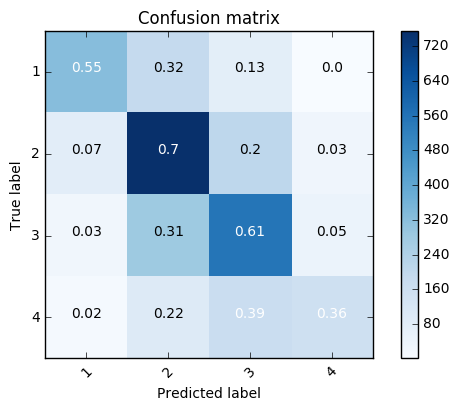

In [37]:
plt.show()

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [38]:
print (bins)

[ 285000.  443250.  601500.  759750.  918000.]
